# Airline Network Analysis

Data comes from a github repository used to analyze a similar problem in an academic paper (JB's data)
Heres the link: https://github.com/000Justin000/spatial_core_periphery?tab=readme-ov-file

## Analysis Goals
1. Understand the structure and properties of global airline networks
2. Identify key network metrics that characterize airline connectivity
3. Explore potential applications of graph theory to real-world problems:
   - **Disease spread modeling**: Understanding how diseases could propagate through airline routes
   - **Airline optimization**: Identifying opportunities to improve global efficiency by adding strategic hubs or connecting flights
   - **2-layer Network**: Exploring how existing hubs could form a small-world network over the whole network.

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

routes = pd.read_csv('routes.dat', header=None)

# Create directed and undirected graphs
G = nx.from_pandas_edgelist(routes, source=2, target=4, create_using=nx.DiGraph())
G_undirected = G.to_undirected()

print(f"Number of airports: {G.number_of_nodes()}")
print(f"Number of routes: {G.number_of_edges()}")

Number of airports: 3425
Number of routes: 37595


# Network Metric Calculations

- The goal of finding these metrics is to understand the current state of the airline network so we can suggest improvements. I believe that efficiency is a good starting metric as it can first tell us the topology of the graph so we can decide what kinds of improvements to make. 

- In our readings, we found that neither small-world nor scale-free is "better" in general. For something like an airline network, we want to be able to find a balance between local and global efficiency so that we have a robust and fault-tolerant network. 

- Since this is a network of airplanes, which should be primarily used for long-distance travel, I think we should consider imrpoving the global efficiency by modeling a 2-layer network that tries to create a larger small-world network from the hubs of the existing network with the largest degrees. 

- We can start with a base network of the largest clique of hubs, then build upon it with other disconnected hubs to build a small-world network from them.

In [ ]:
# Clustering coefficient
avg_clustering = nx.average_clustering(G_undirected)
clustering_per_node = nx.clustering(G_undirected)

# Efficiency metrics
global_eff = nx.global_efficiency(G_undirected)
local_eff = nx.local_efficiency(G_undirected)

# Local efficiency per node
local_eff_per_node = {}
for node in G_undirected.nodes():
    neighbors = list(G_undirected.neighbors(node))
    if len(neighbors) > 1:
        subgraph = G_undirected.subgraph(neighbors)
        local_eff_per_node[node] = nx.global_efficiency(subgraph)
    else:
        local_eff_per_node[node] = 0

# Largest clique
largest_clique = max(nx.find_cliques(G_undirected), key=len)
all_cliques = list(nx.find_cliques(G_undirected))
clique_sizes = [len(c) for c in all_cliques]

# Degree centrality
degree_cent = nx.degree_centrality(G)

print(f"Average Clustering Coefficient: {avg_clustering:.4f}")
print(f"Global Efficiency: {global_eff:.4f}")
print(f"Local Efficiency: {local_eff:.4f}")
print(f"Largest Clique Size: {len(largest_clique)}")
print(f"Airports in largest clique: {largest_clique}")

Average Clustering Coefficient: 0.4871
Global Efficiency: 0.2633
Local Efficiency: 0.5671
Largest Clique Size: 24
Airports in largest clique: ['FLL', 'ATL', 'CLT', 'ORD', 'PHL', 'DTW', 'EWR', 'DFW', 'IAH', 'BOS', 'MCO', 'YYZ', 'DEN', 'MSP', 'LAX', 'LAS', 'PHX', 'STL', 'DCA', 'SFO', 'MKE', 'MCI', 'CLE', 'MSY']


## Clustering Coefficient Visualization

**Left plot - Distribution of Clustering Coefficients:**
- Shows a histogram of clustering coefficients across all airports, red line is the average
- **Interpretation**: 
  - Many airports have a clustering coefficient of 1, suggesting many cliques throughout the network.
  - Many airports also have a clustering coefficient of 0, suggesting many disconnected airports which could be improved with a new connection.

**Right plot - Top 10 Airports by Clustering:**
- Shows the clustering coefficient for the 10 airports with the highest degree (most connections)
- **Interpretation**:
  - High clustering on major hubs suggests these airports serve as connection points between well-connected regional clusters
  - This helps identify which major airports are true "hubs" (connecting many regional clusters) vs. "spokes" (endpoints)

**Application**: Understanding clustering patterns can inform:
- **Disease spread models**: Highly clustered regions might experience faster local spread but slower global spread
- **Network optimization**: Identifying regions with low clustering might indicate opportunities for direct connections that bypass hubs
- **2-layer network**: High clustering airports with large degree could be candidates for the larger 2-layer network.


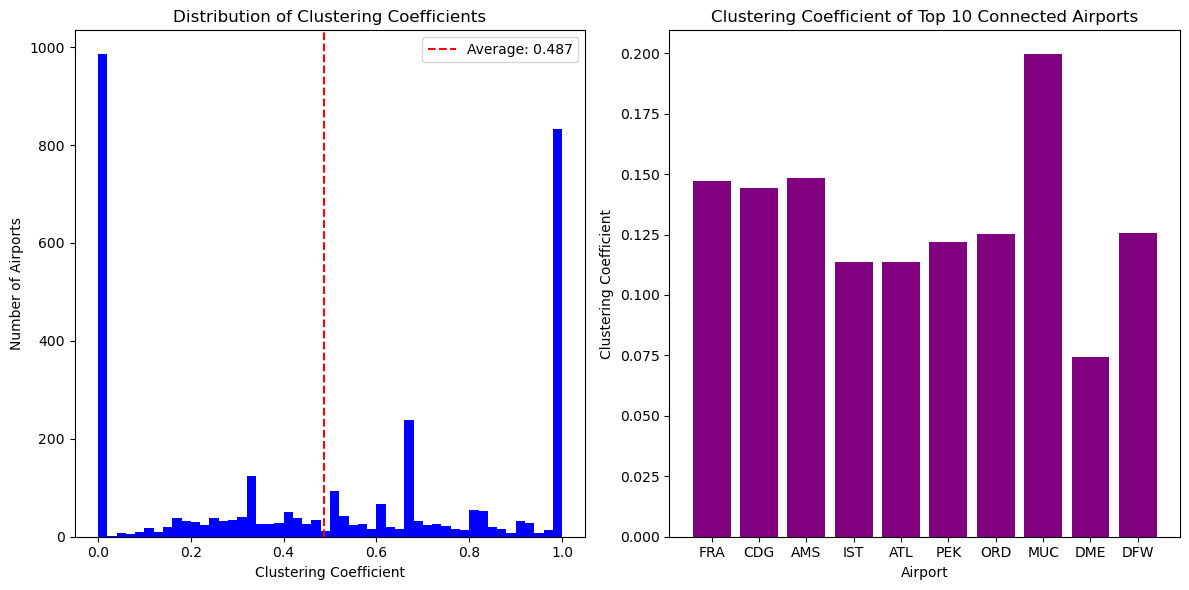

In [3]:
# Histogram of clustering coefficients
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
clustering_values = list(clustering_per_node.values())
plt.hist(clustering_values, bins=50, color='blue')
plt.xlabel('Clustering Coefficient')
plt.ylabel('Number of Airports')
plt.title('Distribution of Clustering Coefficients')
plt.axvline(avg_clustering, color='red', linestyle='--', label=f'Average: {avg_clustering:.3f}')
plt.legend()

# Top 10 airports by degree with clustering
plt.subplot(1, 2, 2)
top_10_airports = sorted(degree_cent.items(), key=lambda x: x[1], reverse=True)[:10]
airports = [a[0] for a in top_10_airports]
clustering_top = [clustering_per_node[a] for a in airports]
plt.bar(airports, clustering_top, color='purple')
plt.xlabel('Airport')
plt.ylabel('Clustering Coefficient')
plt.title('Clustering Coefficient of Top 10 Connected Airports')
plt.tight_layout()
plt.show()

## Efficiency Metric Vizualization

**Left plot - Distribution of Local Efficiency:**
- Shows how local efficiency varies across airports
- The red dashed line shows the network-wide average local efficiency
- **Interpretation**:
  - High local efficiency means that if an airport fails, its neighbors can still operate efficiently among themselves
  - This data shows relatively high local efficiency (0.57) which could tell us that some local connections could be dubious.
  - Since many of the airports have a local efficiency of 1, this indicates a fault tolerant, highly clustered network.
  - Despite this, the most frequent local efficiency was 0 meaning that many airports are only connected to one other airport, or they are in series.
  - This could be useful if we want to explore fault-tolerance or the rate at which disease spreads through airports (if they are in series).

**Right plot - Global vs Local Efficiency Comparison:**
- Compares the overall network efficiency metrics side-by-side
- **Interpretation**:
  - **Global efficiency** 0.26 is a relatively low global efficiency, suggesting that long-distance travel (many flights) is more difficult in this network.
  - **Local efficiency** 0.56 is a relatively high local efficiency score, suggesting that this network is built as a small-world network currently.

**Why this matters**:
- **Disease spread**: Global efficiency affects how quickly diseases spread globally; local efficiency affects regional spread patterns
- **Airline optimization**: Low global efficiency suggests opportunities to add strategic long-distance connections or hubs
- **2-layer network**: Low global and high local suggests ability to alter the current network to include a network of connecting hubs.

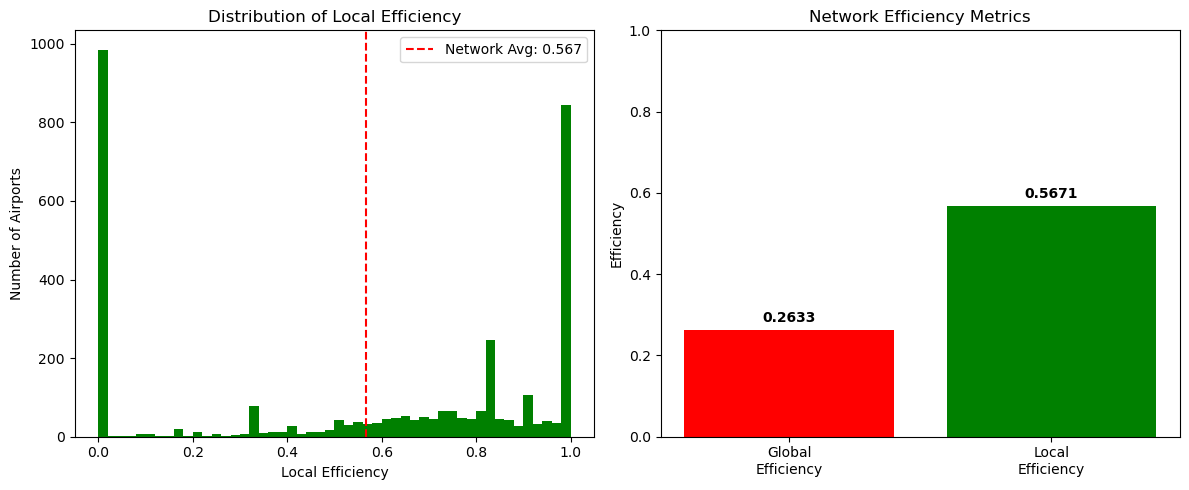

In [4]:
plt.figure(figsize=(12, 5))

# Local efficiency distribution
plt.subplot(1, 2, 1)
plt.hist(list(local_eff_per_node.values()), bins=50, color='green')
plt.xlabel('Local Efficiency')
plt.ylabel('Number of Airports')
plt.title('Distribution of Local Efficiency')
plt.axvline(local_eff, color='red', linestyle='--', label=f'Network Avg: {local_eff:.3f}')
plt.legend()

# Global vs Local efficiency comparison
plt.subplot(1, 2, 2)
metrics = ['Global\nEfficiency', 'Local\nEfficiency']
values = [global_eff, local_eff]
colors = ['red', 'green']
bars = plt.bar(metrics, values, color=colors)
plt.ylabel('Efficiency')
plt.title('Network Efficiency Metrics')
plt.ylim(0, 1)

# Annotate local and global efficiency with values
for bar, v in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        v + 0.02,
        f'{v:.4f}',
        ha='center',
        fontweight='bold'
    )

plt.tight_layout()
plt.show()

## Clique Size Distribution

**What it shows:**
- A histogram showing how many cliques exist at each size
- Clique size ranges from the minimum to maximum clique size found in the network

**Why this matters:**
- **Network Structure**: Large cliques could indicate highly interconnected hub regions, or small worlds with a central hub. 
- **Disease Spread**: Large cliques mean rapid local spread within these groups, but the clique structure might create bottlenecks for global spread
- **Airline Optimization**: Gaps in clique sizes or many small cliques might indicate missing connections that could improve efficiency
- **2-layer Network**: The presence of large cliques suggests these could serve as nodes in a higher-level small-world network. Especially when we consider the cliques with the highest average degree, as these could indicate an existing small-world network made from hubs which we could improve.

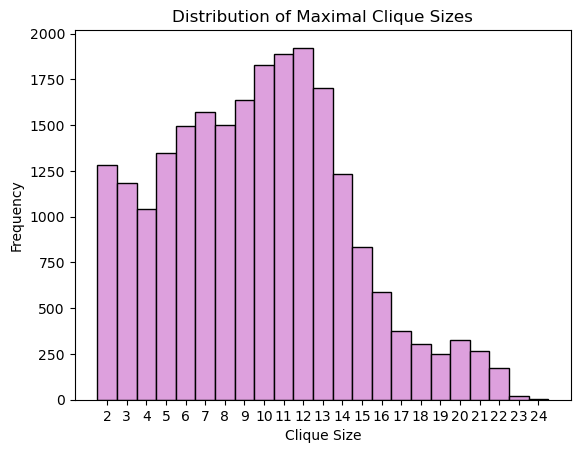

In [ ]:
plt.hist(clique_sizes, bins=range(min(clique_sizes), max(clique_sizes)+2), 
         edgecolor='black', color='plum', align='left')
plt.xlabel('Clique Size')
plt.ylabel('Frequency')
plt.title('Distribution of Maximal Clique Sizes')
plt.xticks(range(min(clique_sizes), (max(clique_sizes)+1)))
plt.show()